We are asumming, the significance:
$$
\kappa=\frac{\sum s_i w_i-N \sqrt{\sum b_i w_i^2}}{\sqrt{\sum\left(s_i+b_i\right) w_i^2}}
$$
where $s_i$ and $b_i$ are the number of signal and background events in the $i$-th bin, and $w_i$ is the weight of the $i$-th bin. The weights are defined as:
$$
w_i=\ln \left(1+\frac{s_i}{b_i}\right)
$$

Note that for a single bin and strong signal, the optimized power of analysis is:
$$
\kappa=\frac{s}{\sqrt{s+b}}
$$

In [105]:
import numpy as np


def approx_global_sig(
    sig: np.array,
    bkg: np.array,
    N: float = 0.0,
    sys_signal: float = 0.0,
    sys_bkg: float = 0.0,
) -> float:
    """
    Calculates the statistical significance of a signal over background in a given
    dataset using a modified version of the formula (S -N sqrt(B))/sqrt(S+B),
    where S is the number of signal events, B is the number of background events,
    and N is the expected number of background sigmas in the signal region.

    Parameters:
    sig (np.array): Array containing the number of signal events in each bin.
    bkg (np.array): Array containing the number of background events in each bin.
    N (float): Expected number of background events in the signal region.
        Default value is 0.0.

    Returns:
    float: The statistical significance of the signal.
    """
    # Calculate weight factor w for each bin
    w = np.log(1.0 + sig / (bkg + 1e-9))

    # Calculate intermediate quantities
    s_w = sig * w
    b_w = bkg * w
    s_ww = sig * w**2
    b_ww = bkg * w**2
    #
    sys_signal = sys_signal * sig
    sys_signal_ww = sys_signal * sys_signal * w**2
    #
    sys_bkg = sys_bkg * bkg
    sys_bkg_ww = sys_bkg * sys_bkg * w**2
    # Calculate numerator and denominator of modified formula
    num = np.sum(s_w) - N * np.sqrt(np.sum(b_ww))
    den = np.sqrt(np.sum(s_ww + b_ww + sys_signal_ww + sys_bkg_ww))

    # Calculate statistical significance and return it
    return num / den

In [106]:
from load_data import histograms, xu_masses, phi_masses

histograms["xu_1000_phi_1"].head()
# histograms["xu_1000_phi_1"].tail()

,bin_center,signal,ttbarmumu,ttbarmumumunu,background
0,0.01,4463.592229,0.005117,0.000004,0.005121
1,0.03,16.598630,0.005141,0.000005,0.005146
2,0.05,9.176478,0.002950,0.000005,0.002955
3,0.07,2.114189,0.002988,0.000005,0.002993
4,0.09,0.944637,0.002669,0.000005,0.002675


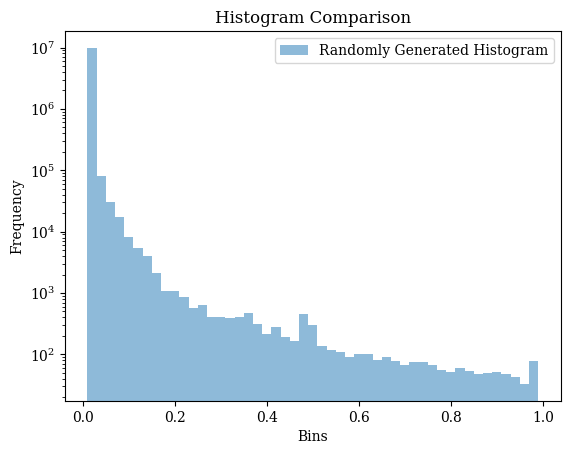

In [117]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace this with your actual dataframe)
bin_centers = np.array(histograms["xu_2000_phi_5"]["bin_center"])
heights = np.array(histograms["xu_2000_phi_5"]["signal"])

# Calculate the probability density function (PDF)
pdf = heights / np.sum(heights)

# Generate random data following the original histogram
random_data = np.random.choice(bin_centers, size=int(1e7), p=pdf)



# # Plot original histogram
# plt.hist(random_data, bins=bin_centers, alpha=0.5, label='Original Histogram')

# Plot randomly generated histogram
plt.hist(random_data, bins=bin_centers, alpha=0.5, label='Randomly Generated Histogram')

plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.legend()
plt.title('Histogram Comparison')
plt.show()

In [107]:
import pandas as pd
from itertools import product

# DataFrame to store the significance values
significances = pd.DataFrame(index=phi_masses, columns=xu_masses)

initial_lumi = 150
final_lumi = 3000
effiecncy = 0.27
rescale_factor = final_lumi * effiecncy / initial_lumi
systematics = 0.20

# Calculate the significance for each bin
for x, y in product(xu_masses, phi_masses):
    sig = histograms[f"xu_{x}_phi_{y}"]["signal"] * rescale_factor
    bkg = histograms[f"xu_{x}_phi_{y}"]["background"] * rescale_factor
    significances.at[y, x] = approx_global_sig(
        sig, bkg, sys_signal=systematics, sys_bkg=systematics, N=3
    )

significances.columns = [f"xu_{int(x)}_GeV" for x in xu_masses]
significances.index = [f"phi_{int(x)}_GeV" for x in phi_masses]
significances

,xu_500_GeV,xu_750_GeV,xu_1000_GeV,xu_1500_GeV,xu_2000_GeV
phi_1_GeV,5.009304,5.013642,5.017941,5.049996,4.988748
phi_5_GeV,5.032121,5.062478,5.064757,5.045222,4.990863
phi_10_GeV,5.182762,5.113597,5.135234,5.061496,5.000047
phi_50_GeV,6.028925,5.573336,5.335556,5.14429,5.086846
phi_100_GeV,7.180582,6.148528,5.780815,5.293028,5.084147
phi_325_GeV,5.628489,5.418352,5.277613,5.144346,5.030778


(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'right': '$\\sqrt{s}$=13TeV, L=3000 fb$^{-1}$, $\\varepsilon=0.27$, sys=20.0%'}, xlabel='$\\chi_{u}$ mass [GeV]', ylabel="$\\phi'$ mass [GeV]">,
 <matplotlib.contour.QuadContourSet at 0x7f13a1ba45b0>)

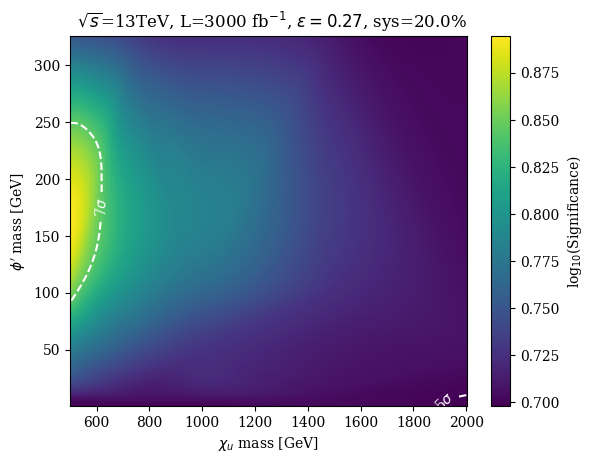

In [108]:
from heatmaps_tools import plot_heatmap, smooth

significances.columns = [float(x) for x in xu_masses]
significances.index = [float(x) for x in phi_masses]
# Convert data to float
significances = significances.astype(float)

lumi = final_lumi
efficiency = effiecncy
sys = systematics

title_right = f"$\sqrt{{s}}$=13TeV, L={lumi} fb$^{{-1}}$, $\\varepsilon={efficiency}$, sys={100*sys}%"
log = True
plot_heatmap(
    smooth(significances, log=log),
    title_right=title_right,
    level_curves = {
        np.log10(5): "5$\sigma$",
        np.log10(7): "7$\sigma$",
    } if log else {
        5.4: "5.5$\sigma$",
        7: "7$\sigma$",
    },
    level_curves_labels_locations = [(650, 175), (1600, 135)],
    x_label="$\chi_{u}$ mass [GeV]",
    y_label="$\phi'$ mass [GeV]",
    cbar_label= "Significance" if not log else "log$_{10}$(Significance)",
    cmap="viridis",
    File_name=f"significance_{lumi}fb_{efficiency}_sys{sys}.png",
)